In [9]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import GPy

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from numpy import genfromtxt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing

from matplotlib import style
style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [21]:
# Loading simulated results for comparsion with SINDy
df_IDM = pd.read_csv('myResults/ASTAZERO1/Exp/Model_1/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_IDM = df_IDM.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_IDM = pd.DataFrame(df_IDM)

df_GIPPS = pd.read_csv('myResults/ASTAZERO1/Exp/Model_2/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_GIPPS = df_GIPPS.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_GIPPS = pd.DataFrame(df_GIPPS)

df_FVDM_CTH = pd.read_csv('myResults/ASTAZERO1/Exp/Model_3/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_FVDM_CTH = df_FVDM_CTH.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_FVDM_CTH = pd.DataFrame(df_FVDM_CTH)

df_FVDM_SIG = pd.read_csv('myResults/ASTAZERO1/Exp/Model_4/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_FVDM_SIG = df_FVDM_SIG.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_FVDM_SIG = pd.DataFrame(df_FVDM_SIG)

In [2]:
df = pd.read_csv('../../../Data/ASTAZERO/dataVehicle1.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

         TIME      LEAD_POS    FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0         1.0   4466.914835   4458.758374  0.021174    0.007862        5.196
1         1.1   4466.916899   4458.759248  0.020108    0.009621        5.196
2         1.2   4466.918861   4458.760291  0.019126    0.011245        5.196
3         1.3   4466.920728   4458.761491  0.018225    0.012739        5.196
4         1.4   4466.922510   4458.762833  0.017404    0.014105        5.196
...       ...           ...           ...       ...         ...          ...
11752  1176.2  27440.670420  27431.138280  0.042988    0.011987        5.196
11753  1176.3  27440.674690  27431.139230  0.042337    0.006957        5.196
11754  1176.4  27440.678880  27431.139640  0.041571    0.001273        5.196
11755  1176.5  27440.682990  27431.139710  0.040687    0.000000        5.196
11756  1176.6  27440.687010  27431.139710  0.039682    0.000000        5.196

[11757 rows x 6 columns]


In [3]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

#t = np.linspace(0, 288.4, 2884, endpoint=False) # 288.4 for JIANG # 188.9 for NAPOLI
t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)

11757
0


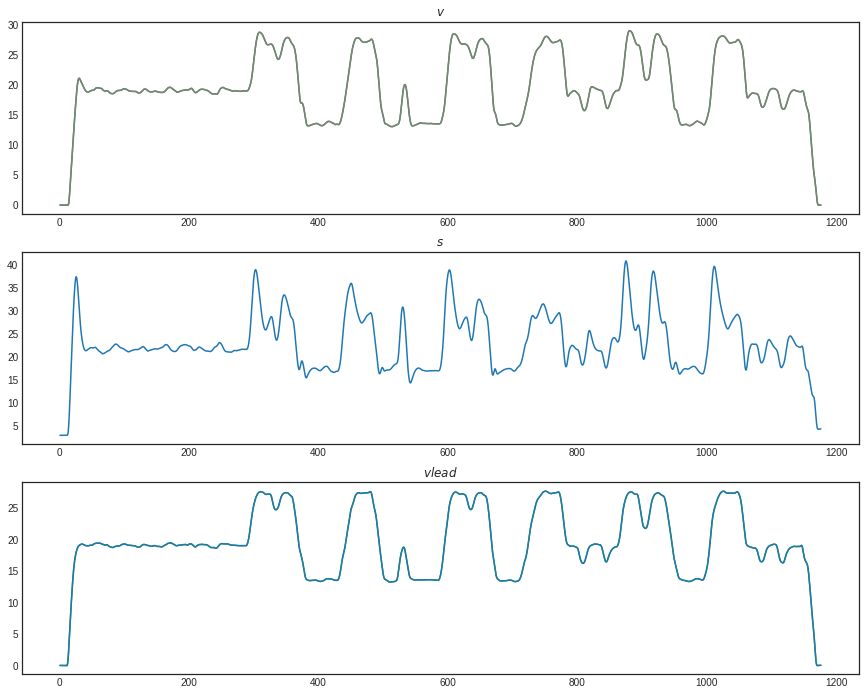

In [4]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

FD_v = FD(followPos[statTraj:endsTraj],t[statTraj:endsTraj])
FD_vlead = FD(leadPos[statTraj:endsTraj],t[statTraj:endsTraj])

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v[statTraj:endsTraj], 'tab:green')
ax1.plot(t[statTraj:endsTraj], FD_v.reshape(followPos[statTraj:endsTraj].shape[0],)[:], 'tab:gray')
ax1.set_title('$v$')
#ax2.plot(t[statTraj:endsTraj], followPos[statTraj:endsTraj], 'tab:green')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj])
#ax2.plot(t[statTraj:endsTraj], leadPos[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.plot(t[statTraj:endsTraj], FD_vlead.reshape(leadPos[statTraj:endsTraj].shape[0],)[:])
ax3.set_title('$vlead$')

plt.show()

# GPy

In [25]:
#st_Traj = 0
#en_Traj = 2308

# Training (UnStandardized)

#X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

#Y_train = v_p[st_Traj:en_Traj].reshape(-1,1)  # RMSE(A)
#Y_train = v[st_Traj+1:en_Traj+1].reshape(-1,1)  # RMSE(V)
#Y_train = s[st_Traj+1:en_Traj+1].reshape(-1,1) # RMSE(S)

# Testing (UnStandardized)

#Y_test = v_p[en_Traj+1:].reshape(-1,1) # RMSE(A)
#Y_test = v[en_Traj+1:].reshape(-1,1)   # RMSE(V)
#Y_test = s[en_Traj+1:].reshape(-1,1)    # RMSE(S)

#X_prior = np.stack((v,s,vlead,t), axis=1) # Prior

In [5]:
st_Traj = 0
en_Traj = 9405 #1551 # 2307 # 9405

# Training (Standardized)
v_mean = v[st_Traj:en_Traj].mean()
v_stdev = v[st_Traj:en_Traj].std()

s_mean = s[st_Traj:en_Traj].mean()
s_stdev = s[st_Traj:en_Traj].std()

vlead_mean = vlead[st_Traj:en_Traj].mean()
vlead_stdev = vlead[st_Traj:en_Traj].std()

v_p_mean = v_p[st_Traj:en_Traj].mean()
v_p_stdev = v_p[st_Traj:en_Traj].std()  

X_train = np.stack(((v[st_Traj:en_Traj]-v_mean)/v_stdev,(s[st_Traj:en_Traj]-s_mean)/s_stdev,(vlead[st_Traj:en_Traj]-vlead_mean)/vlead_stdev,t[st_Traj:en_Traj]), axis=1)

#Y_train = ((v_p[st_Traj+1:en_Traj+1]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
Y_train = ((v[st_Traj+1:en_Traj+1]-v_mean)/v_stdev).reshape(-1,1)  # RMSE(V)
#Y_train = ((s[st_Traj+1:en_Traj+1]-s_mean)/s_stdev).reshape(-1,1) # RMSE(S)

# Testing (Standardized)

#Y_test = ((v_p[en_Traj+1:]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
Y_test = ((v[en_Traj+1:]-v_mean)/v_stdev).reshape(-1,1)       # RMSE(V)
#Y_test = ((s[en_Traj+1:]-s_mean)/s_stdev).reshape(-1,1)       # RMSE(S)

X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [8]:
noise = 0.017

#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)

#myKernel = k1*k2
myKernel = GPy.kern.Exponential(input_dim=3)
gpr = GPy.models.GPRegression(X_train[:,:3], Y_train, kernel=myKernel)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize()

# Display optimized parameter values
display(gpr)

GP_regression.,value,constraints,priors
Exponential.variance,12.259662347531613,+ve,
Exponential.lengthscale,5342.789367794902,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


In [9]:
# Obtain optimized kernel parameters
#l = gpr.mlp.weight_variance.values[0]
#sigma_f = np.sqrt(gpr.mlp.variance.values[0])
#print(l, sigma_f)

# Plot the results with the built-in plot function
mu_s, cov_s = gpr.predict(X_prior[:,:3])
#np.save('ResearchUpdate#43/GPModels/ASTAZERO/GP_Exp_Stand_ASTA(S).npy', gpr.param_array)

In [183]:
#np.savetxt("gp_pred_data.csv", mu_s, delimiter=",")

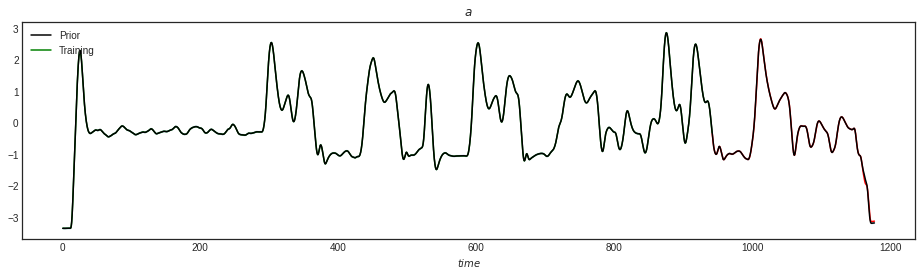

In [10]:
mu = mu_s.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

ax.fill_between(X_prior[:,3], mu + uncertainty, mu - uncertainty, alpha=0.3)
p1, = ax.plot(X_train[:,3], Y_train, 'g')
ax.plot(t[en_Traj+1:], Y_test, 'r')
g1, = ax.plot(X_prior[:,3], mu, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

# RMSE(V)

In [6]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
#myKernel = k1+k2
myKernel = GPy.kern.MLP(input_dim=3)
load_gpr = GPy.models.GPRegression(X_train[:,:3], Y_train, kernel=myKernel, initialize=False)
load_gpr.update_model(False) # do not call the underlying expensive algebra on load
load_gpr.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr[:] = np.load('../GPModels/ASTAZERO/GP_MLP_Stand_ASTA(V).npy') # Load the parameters
load_gpr.update_model(True) # Call the algebra only once
print(load_gpr)


Name : GP regression
Objective : -29560.492557549922
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mlp.variance             |      236.04900189195104  |      +ve      |        
  mlp.weight_variance      |    0.003598108988617891  |      +ve      |        
  mlp.bias_variance        |    0.017392658847995807  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [7]:
X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior
#X_prior = np.stack((v,s,vlead,t), axis=1) # Prior

In [8]:
gp_v = np.zeros(X_prior.shape[0])
cov_s = np.zeros((X_prior.shape[0],X_prior.shape[0]))

gp_pos = np.zeros(X_prior.shape[0])
gp_a = np.zeros(X_prior.shape[0])
gp_s = np.zeros(X_prior.shape[0])

gp_pos[0] = followPos[0]
gp_v[0] = v[0]
gp_a[0] = v_p[0]
gp_s[0] = s[0]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        gp_v[k+1], cov_s[k+1,:] = load_gpr.predict(X_prior[k,:3].reshape(1,-1))
        X_prior[k+1,0] = gp_v[k+1]
        gp_v[k+1] = gp_v[k+1]*v_stdev + v_mean    # UnStandardize
        gp_a[k+1] = (gp_v[k+1]-gp_v[k]) / dt
        gp_pos[k+1] = gp_pos[k] + (gp_v[k+1] + gp_v[k])*(dt) / 2 #+ (0.5)*(gp_a[k])*(dt**2)
        gp_s[k+1] = leadPos[k+1] - gp_pos[k+1] - leadLen[0]
        X_prior[k+1,1] = (gp_s[k+1]-s_mean) / s_stdev

In [14]:
# saving data in csv files 
#uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
#allData = np.stack((gp_v, uncertainty, gp_a, gp_s, v_p, v, s), axis=1)
#np.savetxt('../../../Results/GP/Predictions/ASTAZERO/GP_MLP_Stand_ASTA(V).csv', allData, delimiter=',')

In [17]:
# loading predictions from csv files
my_data = genfromtxt('../../../Results/GP/Predictions/ASTAZERO/GP_MLP_Stand_ASTA(V).csv', delimiter=',')
gp_v = my_data[:,0]
uncertainty = my_data[:,1]
gp_a = my_data[:,2]
gp_s = my_data[:,3]
v_p = my_data[:,4]
v = my_data[:,5]
s = my_data[:,6]

GP Acc. RMSE: 0.09137665039746401
GP Vel. RMSE 0.2323902871663638
GP Head. RMSE 1.0730960438387078
GP Acc. RMSE: 0.11390899598796451
GP Vel. RMSE 0.2696805877706459
GP Head. RMSE 1.1893801641440223


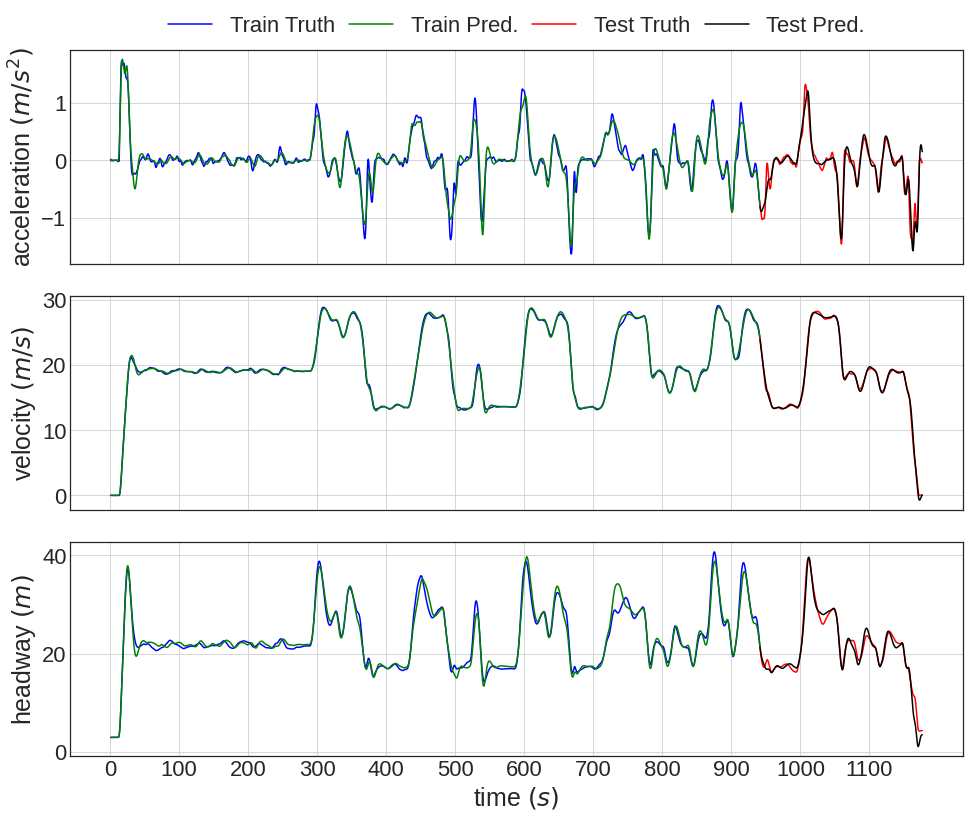

In [19]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

print('GP Acc. RMSE:', np.sqrt(mean_squared_error(gp_a[:en_Traj], v_p[:en_Traj])))
print("GP Vel. RMSE", np.sqrt(mean_squared_error(gp_v[:en_Traj], v[:en_Traj])))
print("GP Head. RMSE", np.sqrt(mean_squared_error(gp_s[:en_Traj], s[:en_Traj])))

print('GP Acc. RMSE:', np.sqrt(mean_squared_error(gp_a[en_Traj:], v_p[en_Traj:])))
print("GP Vel. RMSE", np.sqrt(mean_squared_error(gp_v[en_Traj:], v[en_Traj:])))
print("GP Head. RMSE", np.sqrt(mean_squared_error(gp_s[en_Traj:], s[en_Traj:])))

fig = plt.figure() 

gs = fig.add_gridspec(3, hspace=0.15)
ax = gs.subplots(sharex=True)

fig.set_figheight(13)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

gp_v = gp_v.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

b1, = ax[0].plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax[0].plot(X_prior[:en_Traj,3], gp_a[:en_Traj], "g")
r1, = ax[0].plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax[0].plot(X_prior[en_Traj:,3], gp_a[en_Traj:], "k")
ax[0].set_ylabel('acceleration $(m/s^2)$')
ax[0].grid(True)
ax[0].xaxis.set_ticks(np.arange(min(t), max(t), 100)-1)

ax[1].fill_between(X_prior[:,3], gp_v + uncertainty, gp_v - uncertainty, alpha=0.3)
ax[1].plot(X_train[:,3], v[:en_Traj], "b")
ax[1].plot(X_prior[:en_Traj,3], gp_v[:en_Traj], "g")
ax[1].plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax[1].plot(X_prior[en_Traj:,3], gp_v[en_Traj:], "k")
ax[1].set_ylabel('velocity $(m/s)$')
ax[1].grid(True)

ax[2].plot(X_train[:,3], s[:en_Traj], "b")
ax[2].plot(X_prior[:en_Traj,3], gp_s[:en_Traj], "g")
ax[2].plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax[2].plot(X_prior[en_Traj:,3], gp_s[en_Traj:], "k")
ax[2].set_ylabel('headway $(m)$')
ax[2].grid(True)
ax[2].set_xlabel('time $(s)$')

ax[0].legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test Truth', 'Test Pred.'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)

#plt.savefig('../../../Results/GP/Plots/ASTAZERO/GP_MLP_Stand_ASTA(V).png')
plt.show()